In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
import mat4py
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from imblearn.over_sampling import RandomOverSampler
import pickle as pkl
from style import *
import viz

In [2]:
df = data_tracks.get_data(use_processed=True, use_processed_dicts=True)
n = df.shape[0]
df.keys()

Index(['X', 'Y', 'X_pvals', 'Y_pvals', 'pixel', 'pixel_left', 'pixel_right',
       'pixel_up', 'pixel_down', 'catIdx', 'total_displacement',
       'mean_square_displacement', 'lifetime', 'x_pos', 'y_pos', 'center_max',
       'left_max', 'right_max', 'up_max', 'down_max', 'cell_num', 'X_max',
       'X_min', 'X_mean', 'X_std', 'Y_max', 'Y_mean', 'Y_std', 'rise', 'fall',
       'max_diff', 'min_diff', 'y_score', 'y_thresh', 'y', 'y_single_sig',
       'y_double_sig', 'y_consec_sig', 'sc_0', 'sc_1', 'sc_2', 'sc_3', 'sc_4',
       'sc_5', 'sc_6', 'sc_7', 'sc_8', 'sc_9', 'sc_10', 'sc_11', 'nmf_0',
       'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4', 'nmf_5', 'nmf_6', 'nmf_7', 'nmf_8',
       'nmf_9', 'nmf_10', 'nmf_11', 'X_smooth_spl', 'X_smooth_spl_dx',
       'X_smooth_spl_d2x', 'X_max_spl', 'dx_max_spl', 'd2x_max_spl',
       'num_local_max_spl', 'num_local_min_spl'],
      dtype='object')

# visualize a single example

In [ ]:
# pick a single interesting example
# ex = df[df.lifetime > 250].iloc[0]
ex = df[(df.lifetime > 30) * (df.lifetime < 40) * (df.y_consec_sig == 1)].iloc[0]
plt.figure(dpi=200)
plt.plot(ex['X'], color='red', label='clathrin')
plt.plot(ex['Y'], color='green', label='auxilin')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# basic eda

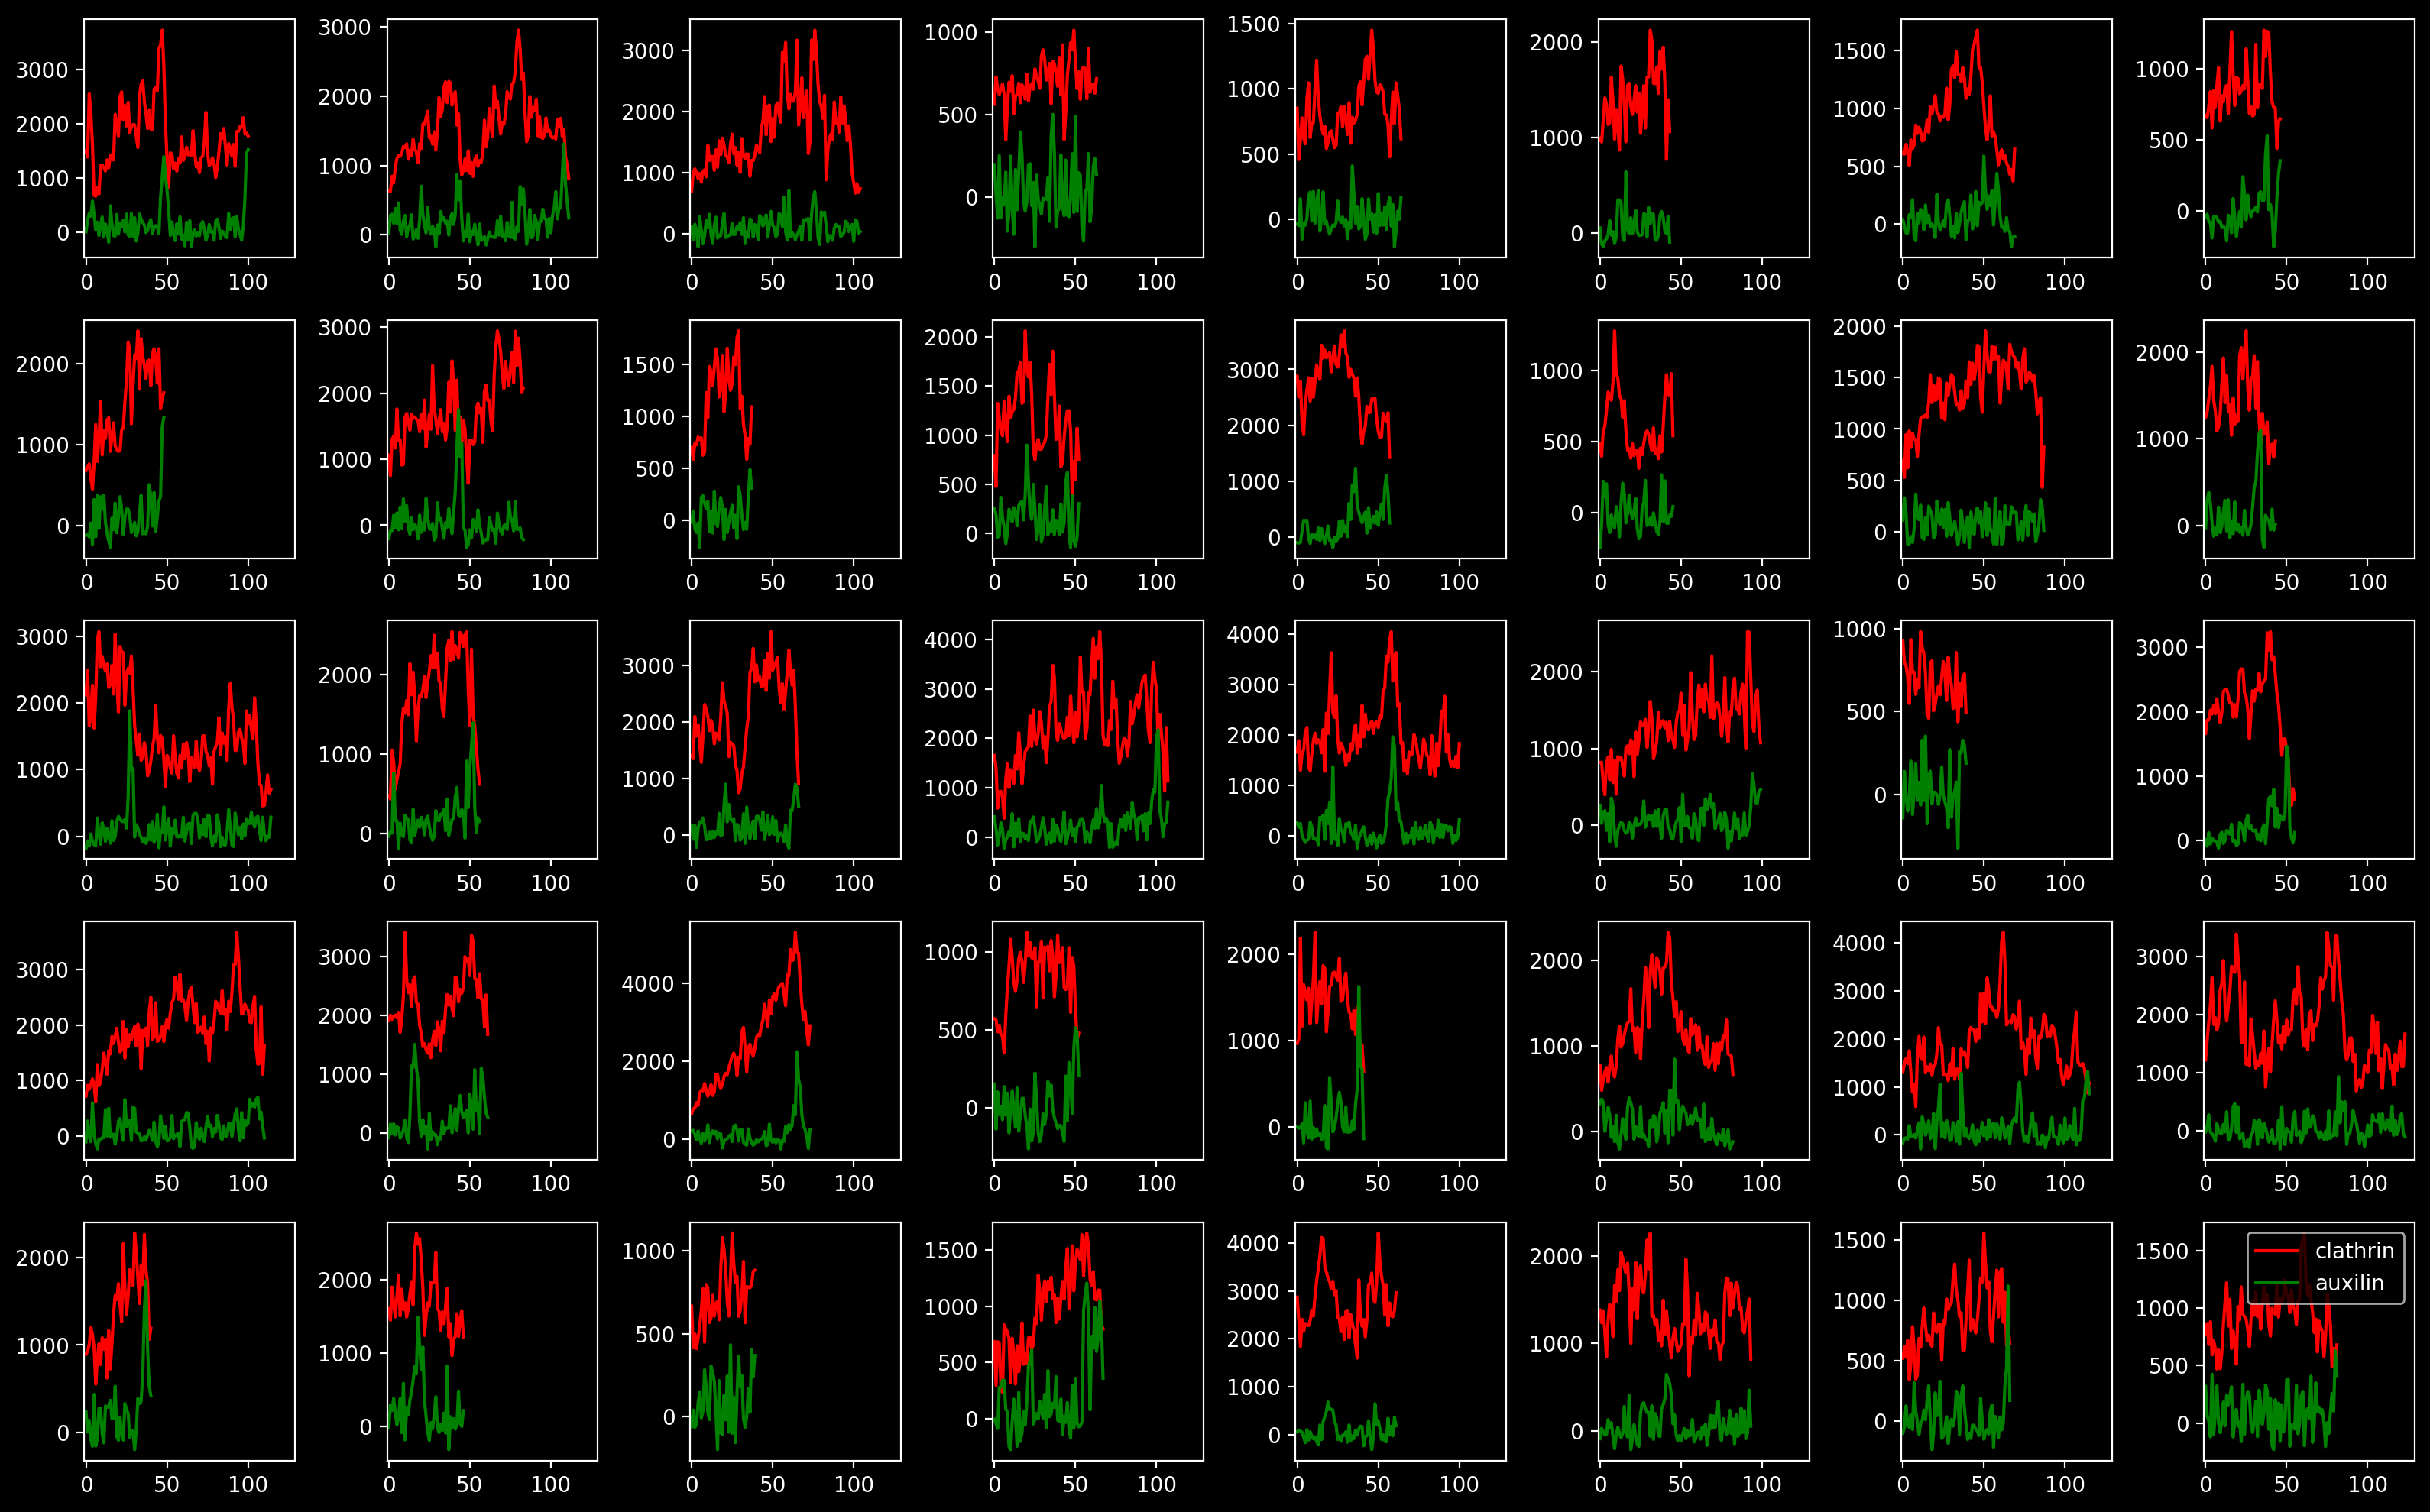

In [28]:
viz.plot_curves(df, hline=False)

In [ ]:
plt.plot(df['x_pos'], df['y_pos'], 'o', alpha=0.1)

# look at learned dictionaries

In [ ]:
print(os.listdir('processed/dictionaries'))
# d = pkl.load(open(f'processed/dictionaries/' + 'sc_12_alpha=1.pkl', 'rb'))
d = pkl.load(open(f'processed/dictionaries/' + 'nmf_12.pkl', 'rb'))
R, C = 3, 4
i = 0
plt.figure(dpi=200)
vmin = d.components_.min()
vmax = d.components_.max()
# print('err', d.reconstruction_err_ / np.linalg.norm(X_mat, ord='fro'))
for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        plt.plot(d.components_[i], color=cr)
        i += 1
        plt.ylim((vmin, vmax))
        if r < R-1:
            plt.xticks([])
        if c > 0:
            plt.yticks([])
plt.tight_layout()
plt.show()

# viz tracks where auxilin peaks first

In [ ]:
X_peak_idx = np.array([np.argmax(x) for x in df.X])
Y_peak_idx = np.array([np.argmax(y) for y in df.Y])
df_err = df[Y_peak_idx < X_peak_idx]
df_err_pos = df_err[df_err.y_consec_sig == 1]
num_pos = df[df.y_consec_sig == 1].shape[0]
num_pos_err = df_err_pos.shape[0] 
frac_pos_err = num_pos_err / num_pos
print('num tot', df.shape[0], 'num aux peaks first', df_err.shape[0], f'frac pos aux peaks first {frac_pos_err:0.2f}')
viz.plot_curves(df_err_pos)

In [ ]:
plt.figure(dpi=300)
plt.hist(df_err_pos.lifetime, bins=20, color=cb)
plt.xlabel('lifetime')
plt.ylabel('count')
plt.title('aux+ with auxilin peaking first')
plt.show()

In [ ]:
viz.plot_curves(df_err, extra_key='X_smooth_spl')

# analyze tracking

In [1]:
fname = f'/scratch/users/vision/data/abc_data/auxilin_data_tracked/A7D2/Cell1_1s/TagRFP/Tracking/ProcessedTracks.mat'
mat = mat4py.loadmat(fname)
tracks = mat['tracks']

In [3]:
i = 2
x = tracks['x'][i][0]
xx = tracks['x'][i][1]

print('clath', len(x), 'aux', len(xx))

clath 300 aux 300


In [ ]:
for i in range(1000):
    print(tracks['t'][i][:5])